In [ ]:
import pandas as pd
import numpy as np
import torch

import time
from google.colab import drive
import nltk
from torch import nn
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

### Google drive file upload

In [ ]:
''' Yesterday I was completely able to put the train.csv file into Google Colab by dragging and dropping.
    Today it's not working at all, way to go, Google Colab, you inconsistent piece of crap. So now I'll
    use Google Drive. But the code works if Google Colab works, JUST CHANGE THE BOOLEAN TO TRUE


    Update 1/14/2024 5:44 pm - It's somehow working again, uploading files to colab.

    Update 1/16/2024 5:03 pm - Now I cannot upload the files directly to colab, using google drive again.

    Update 1/17/2024 5:16 pm - Now it's working again. Not sure why this is so inconsistent.

    Update 1/18/2024 8:54 am - Still working. Great, but still concerned about WHY inconsistency occurs. '''


# Boolean to control how to get the file.
upload_file_to_colab = True

# Dataframe variable
df = None

if upload_file_to_colab is False:
  drive.mount('/content/gdrive')
  df = pd.read_csv('/content/gdrive/MyDrive/train.csv')
else:
  df = pd.read_csv('train.csv')

# 1) Exploratory data analysis

In [ ]:
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
df.shape

(120000, 3)

In [ ]:
# Good to see a balanced dataset.
df['Class Index'].value_counts()

3    30000
4    30000
2    30000
1    30000
Name: Class Index, dtype: int64

### 1.2) Exploring word usage

<Axes: >

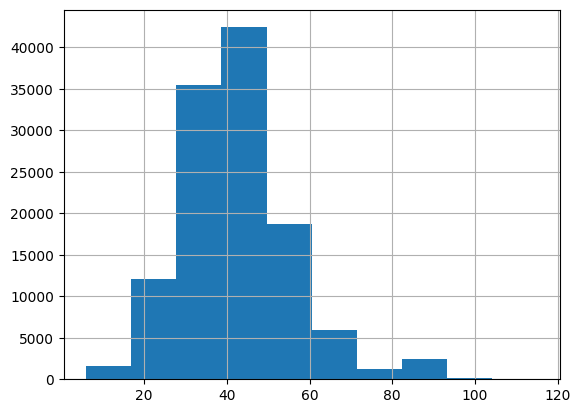

In [ ]:
''' Out of curiousity, view the overall lengths of the Titles vs Descriptions in graphs. The result is as
    expected because titles are always short. Hence why their lengths are between 20 to 60. Yet the descriptions
    are inbetween about 100 and 300. Makes sense. '''
df['Title'].str.len().hist()

<Axes: >

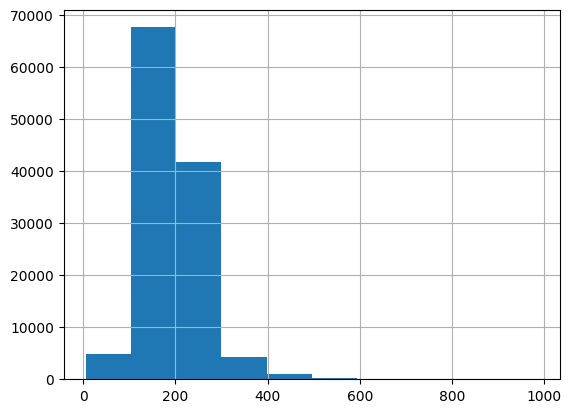

In [ ]:
df['Description'].str.len().hist()

### 1.3) Stop words

In [ ]:
''' Do stop words make up for most of the descriptions? Probably so, and if that's the case that would
    explain, to some extent, why the descriptions lengths are so high. '''

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = nltk.corpus.stopwords.words("english")

print(f'Stop words:\n{stop_words[:10]}\n')
print(f'Stop words length: {len(stop_words)}')

Stop words:
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Stop words length: 179


In [ ]:
''' In order to do this, it's necessary to go through each decription individually and check for stop
    words. Start off by splitting each sentence in the dataframe by using ".str.split()". With a text column/series,
    only ".str" is needed to apply string functionality to the entire column/series. Then convert to
    list for simplicity, so descriptions will be a list of lists. '''

descriptions = df['Description'].str.split()
descriptions = descriptions.values.tolist()

print(descriptions[:2])

[['Reuters', '-', 'Short-sellers,', 'Wall', "Street's", 'dwindling\\band', 'of', 'ultra-cynics,', 'are', 'seeing', 'green', 'again.'], ['Reuters', '-', 'Private', 'investment', 'firm', 'Carlyle', 'Group,\\which', 'has', 'a', 'reputation', 'for', 'making', 'well-timed', 'and', 'occasionally\\controversial', 'plays', 'in', 'the', 'defense', 'industry,', 'has', 'quietly', 'placed\\its', 'bets', 'on', 'another', 'part', 'of', 'the', 'market.']]


In [ ]:
from collections import Counter

# Count all the words seen
c = Counter()

# Loop through sentences, then loop through each stop words and check if sw is in sentence.
for sentence in descriptions:
  for sw in stop_words:
    if sw in sentence:
      # If so, add to counter obj to keep track
      c[sw] += 1

In [ ]:
''' Simply by printing the Counter, it's clear that there's a SIGNIFCANT portion of stop words across all
    descriptions. '''
print(len(c))
print(c)

169
Counter({'the': 91038, 'to': 66522, 'a': 66404, 'of': 62917, 'in': 56938, 'and': 51338, 'on': 39846, 'for': 32278, 'that': 23983, 'with': 19904, 'its': 18079, 'as': 17977, 'is': 17571, 'at': 17529, 'has': 17049, 'by': 15862, 'from': 14541, 'an': 14169, 'it': 13613, 'will': 12326, 'was': 11817, 'his': 11803, 'after': 11136, 'have': 9953, 'be': 9652, 'their': 9179, 'over': 8296, 'are': 8291, 'but': 6860, 'more': 6567, 'this': 6552, 'he': 6386, 'up': 6042, 'against': 5630, 'than': 5618, 'into': 5499, 'who': 5480, 'about': 5357, 'were': 5311, 'been': 5208, 'not': 5123, 'they': 4988, 'out': 4954, 'had': 4853, 'which': 4390, 'when': 3961, 'or': 3331, 'off': 2923, 'some': 2909, 'most': 2768, 'other': 2732, 'can': 2687, 'all': 2574, 'before': 2443, 'just': 2264, 'between': 2207, 'during': 2176, 'down': 2168, 'if': 2030, 'what': 2015, 'no': 1914, 'won': 1910, 'while': 1867, 'being': 1865, 'through': 1829, 'because': 1753, 'only': 1713, 'them': 1693, 'under': 1581, 'her': 1571, 'now': 1540, 

# 2) Tokenization

In [ ]:
from torchtext.data.utils import get_tokenizer

''' Tokenizers are used in nlp to turn strings/sentences into tokens. Ex: "The cat is sleeping" will become
    ['The', 'cat', 'is', 'sleeping'].

    tk = tokenizer '''

tk = get_tokenizer('basic_english')

In [ ]:
''' A tokenizing function with yield in it is necessary because the "yield" keyword will work with iteration. And
    that's what the build_vocab_from_iterator function will do. A vocab is a set of unique words in the dataset, so
    that'll be necessary to create. So yield function -> build_vocab_from_iterator -> Vocab.

    The yield keyword will make sure that the caller that's handling the function in a loop DOESN'T lose it's place so
    it can continue from where it left off. Ex: An array has 3 values [5,10,15], when the loop first runs, the yield
    function returns 5, then next it'll return 10.

    The example below explains in more detail '''

# Just get a couple description sentences for displaying.
test_sentences = df['Description'].values.tolist()[:5]


def test_tokenized_sentence():
  for x in test_sentences:
    yield tk(x)


''' Enumerate just to show numerical order with the "i+1" part. Since the function is looped over, the yield statement
    kicks in every iteration and keeps it's place to continue '''
for i, x in enumerate(test_tokenized_sentence()):
  print(f'---Test sentence #{i+1}---\nOriginal sentence:\n{test_sentences[i]}\nTokenized sentence:\n{x}\n\n')

---Test sentence #1---
Original sentence:
Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Tokenized sentence:
['reuters', '-', 'short-sellers', ',', 'wall', 'street', "'", 's', 'dwindling\\band', 'of', 'ultra-cynics', ',', 'are', 'seeing', 'green', 'again', '.']


---Test sentence #2---
Original sentence:
Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
Tokenized sentence:
['reuters', '-', 'private', 'investment', 'firm', 'carlyle', 'group', ',', '\\which', 'has', 'a', 'reputation', 'for', 'making', 'well-timed', 'and', 'occasionally\\controversial', 'plays', 'in', 'the', 'defense', 'industry', ',', 'has', 'quietly', 'placed\\its', 'bets', 'on', 'another', 'part', 'of', 'the', 'market', '.']


---Test sentence #3---
Original sentence:
Reuters - Soaring crude prices plus worrie

In [ ]:
# This yield func will take in all the sentences to loop over when called. build_vocab_from_iterator will make use of this.
def get_tokenized_sentences(sentences):
  for sent in sentences:
    yield tk(sent)

# Get all sentences into a list and create list for tokenized sentences
all_sentences = df['Description'].values.tolist()

# 3) Vocab

In [ ]:
''' As stated before, to build the vocab, use build_vocab_from_iterator (bvfi) which takes a function as an iterable argument.
    This function takes in an iterable, which makes yield functions great for it. As stated before, the yield will pause
    every iteration to continue from where it left off. Pretty convenient. '''

vocab = build_vocab_from_iterator(get_tokenized_sentences(all_sentences), specials=["<unk>"])

''' The special "unk" key is for when the vocab has to deal with unknown words. When the vocab is built, it will KNOW, n amount
    of words. However if a new word comes in and it's not familar with it, it'll be classified as unk for unknown. '''
vocab.set_default_index(vocab["<unk>"])

In [ ]:
''' Display the numerical conversion of the test sentence: "Reuters - Short-sellers, Wall Street's dwindling\band of
    ultra-cynics, are seeing green again."

    Remember, tk = tokenizer, so the sentence mentioned above is tokenized FIRST, and THEN sent into the vocab object. '''

vocab(tk(test_sentences[0]))

[30, 11, 44988, 3, 420, 332, 17, 9, 60687, 6, 46371, 3, 38, 3595, 812, 421, 1]

# 4) Batches

In [ ]:
''' Issue: I'm using the kaggle dataset. The torchtext dataset is made of tuples of numbers and strings
    (what seems like descriptions) and passes THAT into the data loader so it can get processed. Mine
    currently only has strings. I'd like to keep using the default dataset I got from kaggle, so I
    found a way to put data into a (label, string) format just like the torchtext.datasets AG_NEWS
    dataset with the code below. '''

def dataframe_to_tuples(cur_df):
  list_of_tuples = []

  labels = cur_df['Class Index'].values.tolist()
  descriptions = cur_df['Description'].values.tolist()

  for i in range(len(labels)):
    list_of_tuples.append((labels[i], descriptions[i]))

  return list_of_tuples


list_of_training_tuples = dataframe_to_tuples(df)

list_of_training_tuples[:3]

[(3,
  "Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."),
 (3,
  'Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.'),
 (3,
  'Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.')]

In [ ]:
''' In pytorch, batches are mainly handled with the DataLoader object. The data loader can specify the batch size
    and just as important, the function to edit the batch with the "collate_fn" argument.

    Ex: dl = DataLoader(data, batch_size=64, shuffle=True, collate_fn=some_random_func_to_preprocess_batch_of_data) '''

def preprocess_batch(cur_batch):
  ''' Create lists to hold the labels, sentences/strings and offsets.

        Offsets will be used with an embedding BAG layer for the model. The purpose of the embedding bag layer, stems
        from the original embedding layer. With a regular embedding layer, padding is needed on sentences to go into
        the model.
          Ex:
          ['The', 'cat', 'is', 'sleeping', unk, unk, unk, unk, unk]
          ['I', 'completely', 'forgot', 'to', 'call', 'John', 'yesterday', 'after', 'work']

        Both are length 9 because the first sentence was padded to match the second. But overall this is a waste of
        time and energy. What if the dataset has a max sentence length that's 78 tokens? Or more? ALL the others have
        to be padded to match it, which wastes time. What if the dataset had 1,000, 10,000, or 100,000 sentences and a
        majority needed padding?

        The embedding BAG layer solves this by not caring about padding at all. This layer uses the offset vector, which
        is a separate vector entirely. All the sentences go inside ONE vector/tensor, and the offset vector holds start
        and end positions.

            Ex: The offset vector starts with 0 because it has to start somewhere. Length of first sentence is 29. It
            starts at index 0. Length of second sentence is 42, it starts at index 29, where last sentence ended. Then
            the 3rd s begins at 71 (42 + 29) '''
  labels = []
  sentences = []
  offset_vector = [0]

  # print(f'---Batch---\n{cur_batch}\n')

  # Batches will be in [tuple, tuple, tuple, etc] format.
  for cur_label, cur_sentence in cur_batch:
    # Labels are currently 1 to n (1,2,3,4), make them index from 0 so they'll be 0 to n instead (0,1,2,3).
    labels.append(int(cur_label - 1))

    ''' Sentences must be turned into nums of course. Demonstrated in a previous cell with vocab and tokenizer.

        Ex sentence: "Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."

        Ex sentence after tokenization: ['reuters', '-', 'short-sellers', ',', 'wall', 'street', "'", 's',
          'dwindling\\band', 'of', 'ultra-cynics', ',', 'are', 'seeing', 'green', 'again', '.']

        Ex sentence after vocab: [30, 11, 44988, 3, 420, 332, 17, 9, 60687, 6, 46371, 3, 38, 3595, 812, 421, 1]

        Also typecast into a torch tensor object. The .size() will be used to get how many nums are in the sentence
        after vocab is used. In the above case, it's 17. Also .size() will give the size in the format
        "torch.Size([17])", so indexing does NOT work like ".size[0]" but instead ".size(0)".
    '''
    numeric_sentence = torch.tensor(vocab(tk(cur_sentence)), dtype=torch.int64)
    sentences.append(numeric_sentence)
    offset_vector.append(numeric_sentence.size(0))


  # Convert the types
  labels = torch.tensor(labels, dtype=torch.int64)

  ''' Slicing + Negative indexing in THIS manner (offset_vector[:-1]) means I'll be getting the entire list,
      EXCEPT for the last one. Ex: If [0, 17, 40] exists, then list[:-1] gets "[0, 17]".

      cumsum (when dim=0), works in a way that takes the groups of the numbers in the offset vector to make a
      NEW vector.
        Ex: If offset vector is [1,2,3,4], then cumsum creates new vector.
          1) 1 is first group, it's added to vector to make [1]
          2) 1,2 is second group, all are added and assigned to vector to make [1,3]
          3) 1,2,3 is third group, all are added and assigned to vector to make [1,3,6]
          4) 1,2,3,4 is fourth group, all are added and assigned to vector to make [1,3,6,10]

      Remember the offset vector will store positions of where each sentence starts and ends, and that this
      offset vector refers to the other BIGGER vector that has all the combined numeric sentences in it.

        Ex: Let's say if we have the first 3 sentences (and their numerical conversions):
          1) "Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

              [30, 11, 44988, 3, 420, 332, 17, 9, 60687, 6, 46371, 3, 38, 3595, 812, 421, 1]

                Length 17


          2) 'Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed
              and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on
              another part of the market.'

              [30, 11, 858, 735, 331, 19164, 96, 3, 24132, 26, 4, 3869, 12, 507, 46842, 8, 73428, 2729, 7, 2,
               525, 225, 3, 26, 3465, 75521, 8368, 10, 205, 301, 6, 2, 126, 1]

                Length 34


          3) "Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings
              are expected to\hang over the stock market next week during the depth of the\summer doldrums."

              [30, 11, 2145, 460, 105, 1665, 23876, 2, 360, 8, 2, 1010, 12, 303, 38, 218, 46095, 40, 2, 305,
               126, 106, 80, 179, 2, 7827, 6, 35498, 15416, 1])

                Length 30

          Then we'll have a tensor like:

          "[30, 11, 44988, 3, 420, 332, 17, 9, 60687, 6, 46371, 3, 38, 3595, 812, 421, 1, 30,
            11, 858, 735, 331, 19164, 96, 3, 24132, 26, 4, 3869, 12, 507, 46842, 8, 73428,
            2729, 7, 2, 525, 225, 3, 26, 3465, 75521, 8368, 10, 205, 301, 6, 2, 126, 1 # 51
            30, 11, 2145, 460, 105, 1665, 23876, 2, 360, 8, 2, 1010, 12, 303, 38, 218, 46095,
            40, 2, 305, 126, 106, 80, 179, 2, 7827, 6, 35498, 15416, 1]

          So if the offset vector is like [0,17,51] then it all makes sense. Because the first sentence
          is at start index 0, end index 16. So index 17, is where the NEXT sentence starts, and index
          50 is where it ends. etc etc. Everything comes together. '''
  offset_vector = torch.tensor(offset_vector[:-1]).cumsum(0)

  # Remember at this point the sentences are numeric.
  sentences = torch.cat(sentences)

  return labels, sentences, offset_vector


dl = DataLoader(list_of_training_tuples, batch_size=8, shuffle=False, collate_fn=preprocess_batch)

# 5) Model building

In [ ]:
''' The embedding BAG approach will be used instead of regular embedding. Although a normal embedding
    layer model will be used later on just to see how the 2 compare.  '''

class EmbeddingBagModel(nn.Module):
  def __init__(self, num_classes_to_predict, vocab_size, embedding_size):
    super(EmbeddingBagModel, self).__init__()

    ''' Init all variables.
        1) num_classes_to_predict - The final linear layer will be responsible for how many classes
            to predict.

        2) vocab_size - As said in one of the tokenization cells, a vocab is the set of unique words
            in the dataset.

        3) embedding_size - What size of the vector, the embedding bag layer will return.

        Of course, the output of one layer, is input to the next. Hence why embedding_size is input
        to the linear layer. '''
    self.embedding_bag_layer = nn.EmbeddingBag(vocab_size, embedding_size, sparse=False)
    self.linear_layer = nn.Linear(embedding_size, num_classes_to_predict)
    self.assign_weight_values()



  # Weights can be manually initialized or not.
  def assign_weight_values(self):
    weight_range = 0.5

    # Give both layers weights that range from -value, to +value
    self.embedding_bag_layer.weight.data.uniform_(-weight_range, weight_range)
    self.linear_layer.weight.data.uniform_(-weight_range, weight_range)
    self.linear_layer.bias.data.zero_()



  ''' Forward func takes the input and passes it off, starting from the first layer. Remember, the embedding
      bag layer handles offsets, so it'll take that as well as the batches of text  '''
  def forward(self, sentences, offset_vec):
    values = self.embedding_bag_layer(sentences, offset_vec)
    return self.linear_layer(values)

In [ ]:
# Get the variables set up for the model class.
num_of_classes =  len(set(df['Class Index']))
vocab_size = len(vocab)

# Random embedding size pretty much
embedding_size = 64

eb_model = EmbeddingBagModel(num_of_classes, vocab_size, embedding_size)

In [ ]:
for x in dl:
  print(x)
  break

(tensor([2, 2, 2, 2, 2, 2, 2, 2]), tensor([   30,    11, 44988,     3,   420,   332,    17,     9, 60687,     6,
        46371,     3,    38,  3595,   812,   421,     1,    30,    11,   858,
          735,   331, 19164,    96,     3, 24132,    26,     4,  3869,    12,
          507, 46842,     8, 73428,  2729,     7,     2,   525,   225,     3,
           26,  3465, 75521,  8368,    10,   205,   301,     6,     2,   126,
            1,    30,    11,  2145,   460,   105,  1665, 23876,     2,   360,
            8,     2,  1010,    12,   303,    38,   218, 46095,    40,     2,
          305,   126,   106,    80,   179,     2,  7827,     6, 35498, 15416,
            1,    30,    11,   681,    35,  5248,    83, 61940,    29,     2,
          748,  3184,     7,   471,    97, 52280,   560,     4,   992,  2536,
           92, 81694,     3,    28,    83,   281,    23,    10,    99,     1,
          152,    11, 82575,    54,    83,   105,     3,  9565,  1725,     8,
        13320,  8818,     3, 

# 6) Get model training ready

In [ ]:
''' Learning rate determines how big "steps" are to take to get to lowest loss. too big? Might not get that
    sweet spot. Too small? Might take FOREVER to converge and that's a fate worse than death when speed is
    almost always a top priority. '''
# learning_rate = 5
learning_rate = 0.1

# Epochs are how many times to train the model.
epochs = 10

# How big should each batch be for training? Definitely influences speed
batch_size = 64

# Loss gets differences between predictions and ground truths. CrossEntropyLoss is good for classification as well
cel = torch.nn.CrossEntropyLoss()

''' Optimizers adjusts the model params to lessen model error every epoch. Using stochastic gradient descent.
    It'll get the gradients and multiply them by a small factor (learning rate), take the result and subtract
    it FROM the weights in order to get closer to 0. '''
optimizer = torch.optim.SGD(eb_model.parameters(), lr=learning_rate)

# Scheduler adjusts the learning rate/lr based on # of epochs.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [ ]:
''' DataLoader is needed because batches of data will be taken from it when it's looped over.
    Ex: "for x in dl:
           print(x)
           break"
    This will print a batch of determined size with labels, concatenated numerical sentences and
    the offset vector. '''
def train_model(cur_data_loader):
  eb_model.train()

  # Accuracy = dividing how many the model got RIGHT out of a batch, vs the total IN the batch. Lists are for evaluation metrics.
  acc = 0
  count = 0
  train_accuracies = []
  train_losses = []

  log_interval = 500

  # Timing is important to track exactly where we're at.
  start_time = time.time()

  ''' Begin loop to access data that dataloader has. As stated before, with each iteration over the data
      loader, it will return a labels, numeric sentences, and the offset vector

      1) .zero_grad() - This sets all the weights of the gradients to 0. Absolutely necessary because if
           .backward() is later used on a loss function while the gradients are NOT 0 (starting from a default
           position), the gradients will stack and therefore computation numbers will be off.


      2) prediction - In THIS specific case, remember there's 4 values for predictions which are: 1,2,3,4
          (as seen with the code "df['Class Index'].value_counts()")

            ALSO, the data loaders batch size I put when it was created was 8. So each one represents a
            numerical sentence. So for predictions, it makes sense why the prediction is a tensor of
            size 8 rows, 4 columns. A row for every sentence, and a column for type.

            Ex:
              "tensor([[-1.4874, -1.7169,  5.1553, -1.7523],
                      [-1.4961, -1.4595,  4.3765, -1.4398],
                      [-1.3510, -1.2007,  4.2347, -1.4479],
                      [-1.4007, -1.2626,  3.9441, -1.2419],
                      [-1.4098, -1.4356,  4.4891, -1.3810],
                      [-1.2410, -1.2840,  4.2341, -1.2046],
                      [-1.2385, -1.2613,  3.8466, -1.1498],
                      [-1.6010, -1.3493,  4.3046, -1.4361]], grad_fn=<AddmmBackward0>)"

            That's why argmax is used because argmax() will find the greatest values in a 2d matrix.
            If it's given 1? It'll find the greatest values row by row and get the indices. If the ground
            truths are "tensor([2, 2, 2, 2, 2, 2, 2, 2])" and in each row, it's clear that index 2 is what
            the model will predict, it seems it got everything correct.

            Comparing them both like predictions.argmax(1) == ground_truths will return a boolean tensor
            such as "tensor([True, True, True, True, True, True, True, True])" Basically meaning "Hey, the
            model got THIS many right, out of the batch". then sum.item() will get the numerical version of
            how many it got right, like in the previous tensor that's 8/8, so the number will be 8


      2) cel - CrossEntropyLoss, and as said before, losses get the difference between the predictions
          and the ground truths (what the REAL label was).


      3) .backward() - Use back propagation to update the models weights after predicting.


      4) grad_norm - https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html
          A norm value is applied to all gradients as if they're in one vector, and gradients are modified
          in place.


      5) .step() - Update the gradients weights. How? I previous stated "Using stochastic gradient descent.
          It'll get the gradients and multiply them by a small factor (learning rate), take the result and
          subtract it FROM the weights in order to get closer to 0.


      6) Update accuracy and count - Accuracy will be how many the model got right, vs how many were total
          in the batch. Explained in more detail in step 2.

      7) Modulus - Used so we can see updates in a good fashion.
          Ex: "val = 500
                 for i in range(1, 100):
                    if 500 % i == 0:
                        print(f'i: {i}')"
               i MUST start at one or a division by 0 error will occur. But, with code above, it gave me
               back the numbers: "1,2,4,5,10,20,25,50". So this makes a gap to display updates.  '''
  for i, (label, sentences, offset_vector) in enumerate(cur_data_loader):
    optimizer.zero_grad()

    prediction = eb_model(sentences, offset_vector)

    loss = cel(prediction, label)

    # For evaluation metrics
    train_losses.append(loss)

    loss.backward()

    torch.nn.utils.clip_grad_norm_(eb_model.parameters(), 0.1)

    optimizer.step()

    # print(f'Prediction: {prediction}\nGround truths:\n{label}\n')
    boolean_tensor = (prediction.argmax(1) == label)
    # print(f'Prediction argmax and label:\n{boolean_tensor}\n\n')
    num_of_correct_predictions = boolean_tensor.sum().item()

    acc = acc + num_of_correct_predictions
    count = count + label.size(0)

    # For evaluation metrics.
    train_accuracies.append(acc / count)

    if i % log_interval == 0 and i > 0:
      # See how much time it took to get here.
      elapsed = time.time() - start_time

      # Print info to see
      print(
          "| epoch {:3d} | {:5d}/{:5d} batches "
          "| accuracy {:8.3f}".format(
              epochs, i, len(cur_data_loader), acc / count
          )
      )

      # After this pause to show information, reset variables.
      acc, count = 0, 0
      start_time = time.time()

  # For evaluation metric
  return train_accuracies, train_losses

In [ ]:
# Get test data loaded. tdf = test dataframe
tdf = None

if upload_file_to_colab is False:
  tdf = pd.read_csv('/content/gdrive/MyDrive/test.csv')
else:
  tdf = pd.read_csv('test.csv')

tdf.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [ ]:
# Use func to get tuples
list_of_testing_tuples = dataframe_to_tuples(tdf)

list_of_testing_tuples[:5]

[(3,
  "Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."),
 (4,
  'SPACE.com - TORONTO, Canada -- A second\\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\\privately funded suborbital space flight, has officially announced the first\\launch date for its manned rocket.'),
 (4,
  'AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.'),
 (4,
  "AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar."),
 (4,
  "AP - Southern California's smog-fighting agency went after emissions of the bovine variety Fri

In [ ]:
''' Validation data isn't really MANDATORY but it'll sure help the model a LOT. So why not use some. The kaggle
    link (https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset) for this dataset only has
    train and test, so a valid dataset will be built in another way.

    Start by using the first line of code below. Can also do len(df) since it was created from train data, same
    thing. Also multiplying by a decimal value will get that large of a portion OF the original size. Ex:
    120,000 * 0.50 = 60,000, so that's half. '''

train_size = int(len(list_of_training_tuples) * 0.95)

In [ ]:
from torch.utils.data.dataset import random_split

new_train_data, new_valid_data = random_split(list_of_training_tuples, [train_size, len(list_of_training_tuples) - train_size])

print(len(new_train_data))
print(len(new_valid_data))

114000
6000


In [ ]:
new_train_data.dataset[:3]

[(3,
  "Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."),
 (3,
  'Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.'),
 (3,
  'Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.')]

In [ ]:
# Since data exists for train, test, and valid, create data loaders for each.
train_dl = DataLoader(new_train_data.dataset, batch_size=batch_size, shuffle=True, collate_fn=preprocess_batch)
valid_dl = DataLoader(new_valid_data.dataset, batch_size=batch_size, shuffle=True, collate_fn=preprocess_batch)
test_dl = DataLoader(list_of_testing_tuples, batch_size=batch_size, shuffle=True, collate_fn=preprocess_batch)

### 6.2) Creating testing function

In [ ]:
''' Pretter similar to the train function in all honesty. Minor differences.

    1) .eval() - Turns off dropout layers that were used during training
    2) no_grad() - Use for predictions to ensure no gradient calculations. All requires_grad flags are
        set to false. '''

def test(cur_dl):
  eb_model.eval()

  acc = 0
  count = 0
  loss = 0

  with torch.no_grad():
    for i, (label, sentences, offset_vector) in enumerate(cur_dl):
      prediction = eb_model(sentences, offset_vector)
      loss = cel(prediction, label)

      boolean_tensor = (prediction.argmax(1) == label)
      num_of_correct_predictions = boolean_tensor.sum().item()
      acc = acc + num_of_correct_predictions
      count = count + label.size(0)

  return (acc / count), loss

### 6.3) Training model

In [ ]:
total_acc = None

# For evaluation metrics.
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

# Real training, of course iterate for however many num of epochs.
for i in range(epochs):
  # Begin timing on the training process
  time_start = time.time()

  # Both train and test return metrics
  cur_train_accuracies, cur_train_losses = train_model(train_dl)
  test_accuracy, test_loss = test(valid_dl)

  # For evaluation metrics.
  train_accuracies.append(cur_train_accuracies)
  train_losses.append(cur_train_losses)

  test_accuracies.append(test_accuracy)
  test_losses.append(test_loss)

  ''' First run? total_accu is none. Second run, make sure it's bigger than the recent test result. Also
      remember scheduler.step adjusts lr based on # of epochs. '''
  if total_acc is not None and total_acc > test_accuracy:
    scheduler.step()
  else:
    total_acc = test_accuracy



  print("-" * 59)
  print(
      "| end of epoch {:3d} | time: {:5.2f}s | "
      "valid accuracy {:8.3f} ".format(
          i, time.time() - time_start, test_accuracy
      )
  )
  print("-" * 59)

| epoch  10 |   500/ 1875 batches | accuracy    0.293
| epoch  10 |  1000/ 1875 batches | accuracy    0.366
| epoch  10 |  1500/ 1875 batches | accuracy    0.417
-----------------------------------------------------------
| end of epoch   0 | time: 45.60s | valid accuracy    0.467 
-----------------------------------------------------------
| epoch  10 |   500/ 1875 batches | accuracy    0.482
| epoch  10 |  1000/ 1875 batches | accuracy    0.501
| epoch  10 |  1500/ 1875 batches | accuracy    0.530
-----------------------------------------------------------
| end of epoch   1 | time: 46.74s | valid accuracy    0.554 
-----------------------------------------------------------
| epoch  10 |   500/ 1875 batches | accuracy    0.558
| epoch  10 |  1000/ 1875 batches | accuracy    0.588
| epoch  10 |  1500/ 1875 batches | accuracy    0.595
-----------------------------------------------------------
| end of epoch   2 | time: 44.01s | valid accuracy    0.622 
-------------------------------

# 7) Model evaluation

In [ ]:
''' Issue: The first graph attempt wasn't sensible. Lines up and down for all_training_accuracies. When looking at the
    2d list all_training_accuracies closer, some values in inner lists are actually DECREASING.

    Ex portion of an inner list in all_training_accuracies:
    "[0.96875,
      0.9765625,
      0.96875,
      0.96484375,
      0.95625,
      0.9427083333333334,
      0.9441964285714286,
      0.939453125,
      0.9409722222222222,
      0.94375,
      0.9375,
      0.9375]"

    With that said, a good solution might be to get the mean, which is the sum of the values in a list divided by
    total nums. So the list comprehension below will take all inner lists of nums and get the means of each in
    one list.

    Somewhat the same process with the losses. But with them, a list in the 2d list will look like:
    "[tensor(1.4096, grad_fn=<NllLossBackward0>), tensor(1.3890, grad_fn=<NllLossBackward0>), etc] '''

_train_accuracies = [np.mean(train_accs) for train_accs in train_accuracies]

# _train_losses = [np.mean(losses) for losses in train_losses]

_train_losses = []
for tl in train_losses:
  # Convert each tensor list into regular floats
  tensor_to_floats = [t.data.item() for t in tl]
  _train_losses.append(np.mean(tensor_to_floats))

print(f'Training accuracies:\n{_train_accuracies}\n\nTraining losses:\n{_train_losses}')

Training accuracies:
[0.36480028788851326, 0.5094025512905354, 0.5844056353915771, 0.6440684100657258, 0.6934753865875374, 0.7283645718993612, 0.7533275181659119, 0.7735961134560218, 0.7858344126630873, 0.7994912151395339]

Training losses:
[1.3442758415857952, 1.2334499081929524, 1.1022219162623088, 0.9753563533465067, 0.8686167806625367, 0.7836107541720072, 0.7175545816580454, 0.6653441174030303, 0.6235796196460723, 0.5897582337379456]


In [ ]:
# Same process for test LOSSES, not accuracies. Test accuracies is 1d, while losses are in tensor form described above.
_test_losses = []
for tl in test_losses:
  _test_losses.append(tl.data.item())

print(f'Testing accuracies:\n{test_accuracies}\n\nTest losses:\n{_test_losses}')

Testing accuracies:
[0.46685, 0.553925, 0.6219583333333333, 0.6750916666666666, 0.7141916666666667, 0.7434916666666667, 0.7642333333333333, 0.782375, 0.7952083333333333, 0.8064583333333334]

Test losses:
[1.2835649251937866, 1.1526228189468384, 1.0034509897232056, 0.8460972309112549, 0.854055643081665, 0.7282232642173767, 0.707172155380249, 0.650678277015686, 0.598831295967102, 0.4175674617290497]


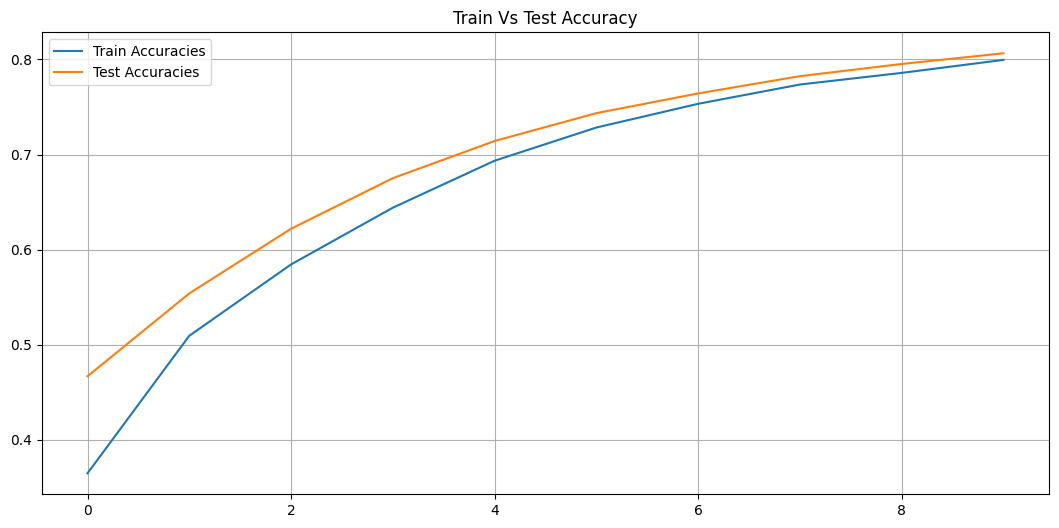

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(13,6))

plt.plot(_train_accuracies, label='Train Accuracies')
plt.plot(test_accuracies, label='Test Accuracies')
plt.title('Train Vs Test Accuracy')
plt.legend()
plt.grid()

plt.show()

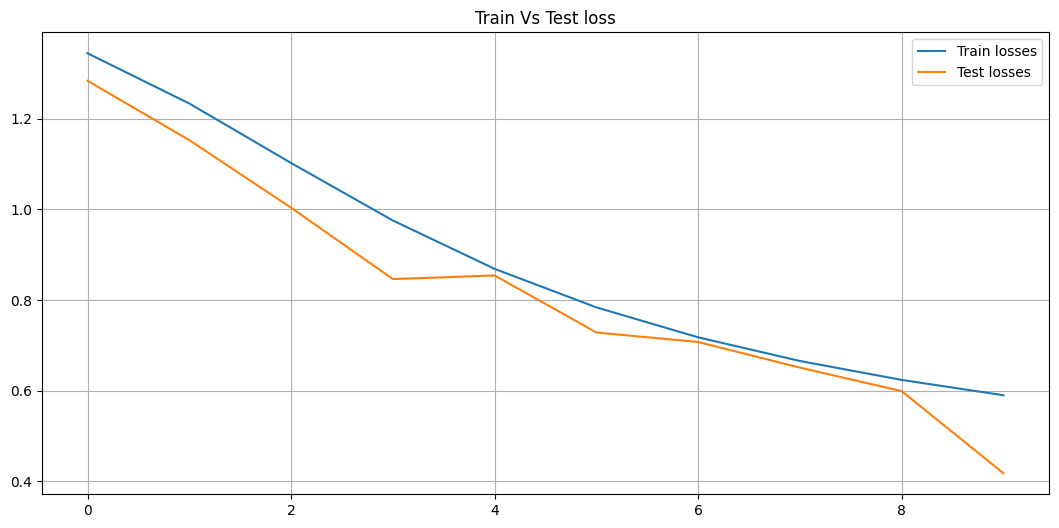

In [ ]:
import matplotlib.pyplot as plt


''' Issue here: Clearly the test loss line is ridiculous. Looking at the data camp link:
    https://www.datacamp.com/tutorial/nlp-with-pytorch-a-comprehensive-guide , his is just fine. How?

    Googled "pytorch loss up and down" and got:

    1) https://stats.stackexchange.com/questions/515314/why-is-my-training-loss-going-up-and-down-all-the-time

      Problem could be scaling. That's fair, I definitely never SCALED the numbers.


    2) https://discuss.pytorch.org/t/why-my-training-loss-goes-down-and-up-again/33101
      This solved it. Recommended editing the learning rate '''

fig = plt.figure(figsize=(13,6))

plt.plot(_train_losses, label='Train losses')
plt.plot(_test_losses, label='Test losses')
plt.title('Train Vs Test loss')
plt.legend()
plt.grid()

plt.show()

# 8) Embedding model comparison

In [ ]:
''' The PREVIOUS model used the embedding bag layer in its model. That layer doesn't bother with padding and instead
    uses the offset vector to get the start and end positions of various sentences (that have been put into one tensor)
    to do its calculations. See "preprocess_batch" function again for notes in the comments I wrote.

    But what if I started with a regular embedding model? Would be interesting to see how good
    the embedding bag layer model does in comparison. Start by seeing the original data again.  '''

df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
# This is the TEST dataframe. Remember there's train.csv and test.csv for this project.
tdf.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [ ]:
''' Data loaders handle batches of data to the model, and giving a Data loader a function in its "collate_fn"
    arg will have data preprocessed. This preprocess function is very similar to "preprocess_batch" for the
    embedding bag model, so not too much to explain here.

    The padding size for each batch will be different. That's honestly not a bad way to go about it. Why?
      1) If first batch given has a sentence of max length 21, and the next batch? 30. Next batch? 55.
          Then each batch won't have to adhere to a universal MAX length. For example, when the training
          sentences are converted to numbers, the max length of ALL of the converted sentences
          turned out to be 203. Making sure EVERY batches sentences are that long seems unnecessary.   '''

def embedding_preprocess_batch(cur_batch):
  labels = []
  sentences = []

  ''' Batches come in list form, and since list_of_training_tuples is what it's given, each index in list
      will be a tuple.
        Ex: "[(3, "Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics,
             are seeing green again."), (3, 'Reuters - Private investment firm Carlyle Group,\\which has
             a reputation for making well-timed and occasionally\\controversial plays in the defense
             industry, has quietly placed\\its bets on another part of the market.')]"

      Now as stated in previous comment, find the max length of the batch. First get the sentences in
      numerical format. Then use mapping to get  '''

  num_sentence_batch = [vocab(tk(cur_tuple[1])) for cur_tuple in cur_batch]
  max_pad_length = max(map(len, num_sentence_batch))
  # print(f'Max pad length: {max_pad_length}')

  # Batches are in tuple list format like "[tuple, tuple, tuple, etc]".
  for i, (cur_label, cur_sentence) in enumerate(cur_batch):
    # Decrement labels like before.
    labels.append(int(cur_label - 1))

    # tk tokenizes sentence, vocab turns it into numbers, convert to tensor and use padding.
    num_sentence = torch.tensor(num_sentence_batch[i])
    num_sentence = torch.nn.functional.pad(num_sentence, (0, max_pad_length - len(num_sentence)), mode='constant', value=0)
    sentences.append(num_sentence)


  # Convert the types
  labels = torch.tensor(labels, dtype=torch.int64)
  sentences = torch.stack(sentences)

  return labels, sentences


# tdl = TEST DataLoader variable. Used for display.
tdl = DataLoader(list_of_training_tuples, batch_size=8, shuffle=False, collate_fn=embedding_preprocess_batch)
for x in tdl:
  print(x)
  break

(tensor([2, 2, 2, 2, 2, 2, 2, 2]), tensor([[   30,    11, 44988,     3,   420,   332,    17,     9, 60687,     6,
         46371,     3,    38,  3595,   812,   421,     1,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [   30,    11,   858,   735,   331, 19164,    96,     3, 24132,    26,
             4,  3869,    12,   507, 46842,     8, 73428,  2729,     7,     2,
           525,   225,     3,    26,  3465, 75521,  8368,    10,   205,   301,
             6,     2,   126,     1,     0,     0,     0,     0],
        [   30,    11,  2145,   460,   105,  1665, 23876,     2,   360,     8,
             2,  1010,    12,   303,    38,   218, 46095,    40,     2,   305,
           126,   106,    80,   179,     2,  7827,     6, 35498, 15416,     1,
             0,     0,     0,     0,     0,     0,     0,     0],
        [   30,    11,   681,    35,  5248,    83, 61940

### 8.2) Embedding model building

In [ ]:
# Extremely similar to embedding bag model, won't reiterate too much again about how it works.

class EmbeddingModel(nn.Module):
  def __init__(self, num_classes_to_predict, vocab_size, embedding_size):
    super(EmbeddingModel, self).__init__()
    self.embedding_layer = torch.nn.Embedding(vocab_size, embedding_size)
    self.linear_layer = torch.nn.Linear(embedding_size, num_classes_to_predict)
    # self.assign_weight_values()


  # Improvements: It's worth a try to manually init weights. Keep as much as the same as possible for comparison.

  # # Weights can be manually initialized or not.
  # def assign_weight_values(self):
  #   weight_range = 0.5

  #   # Give both layers weights that range from -value, to +value
  #   self.embedding_layer.weight.data.uniform_(-weight_range, weight_range)
  #   self.linear_layer.weight.data.uniform_(-weight_range, weight_range)
  #   self.linear_layer.bias.data.zero_()


  def forward(self, x):
    x = self.embedding_layer(x)
    x = torch.mean(x, dim=1)
    return self.linear_layer(x)

In [ ]:
''' Important variables like:

    1) num_classes - How many classes to predict
    2) vocab_size - How many unique words in the data.
    3) embedding size - dimensions for embedding layer
    4) learning_rate - Adjusts steps while going to optimal point.
    5) epochs - How many times to train
    6) batch_size - How big a batch of data to handle at once.
    7) cel (loss func) - The loss func to use.
    8) optimizer - adjusts the model params to lessen model error every epoch.
    9) scheduler - adjusts the learning rate/lr based on # of epochs

    Are needed. '''

''' Improvements: Since I discovered the optimized and scheduler were the issue, I can try getting rid of redeclarations. Follow
    the coding principle DRY, don't repeat yourself. '''

num_of_classes =  len(set(df['Class Index']))
vocab_size = len(vocab)
embedding_size = 64

embedding_model = EmbeddingModel(num_of_classes, vocab_size, embedding_size)

In [ ]:
learning_rate = 0.1
epochs = 10
batch_size = 64
cel = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(embedding_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

### 8.3) Embedding model training function

In [ ]:
def train_embedding_model(cur_data_loader):
  embedding_model.train()

  ''' Accuracy = dividing how many the model got RIGHT out of a batch, vs the total IN the batch. Lists
      are for evaluation metrics. '''
  acc = 0
  count = 0
  train_accuracies = []
  train_losses = []

  log_interval = 500

  # Timing is important to track exactly where we're at.
  start_time = time.time()

  for i, (label, sentences) in enumerate(cur_data_loader):
    optimizer.zero_grad()

    prediction = embedding_model(sentences)

    loss = cel(prediction, label)

    # For evaluation metrics
    train_losses.append(loss)

    loss.backward()

    torch.nn.utils.clip_grad_norm_(eb_model.parameters(), 0.1)

    optimizer.step()

    boolean_tensor = (prediction.argmax(1) == label)

    num_of_correct_predictions = boolean_tensor.sum().item()

    acc = acc + num_of_correct_predictions
    count = count + label.size(0)

    # For evaluation metrics.
    train_accuracies.append(acc / count)

    if i % log_interval == 0 and i > 0:
      # See how much time it took to get here.
      elapsed = time.time() - start_time

      # Print info to see
      print(
          "| epoch {:3d} | {:5d}/{:5d} batches "
          "| accuracy {:8.3f}".format(
              epochs, i, len(cur_data_loader), acc / count
          )
      )

      # After this pause to show information, reset variables.
      acc, count = 0, 0
      start_time = time.time()

  # For evaluation metric
  return train_accuracies, train_losses

### 8.4) Data loaders and test function

In [ ]:
''' A few things have already been done regarding the embedding BAG model:

    1) Using list_of_training_tuples/list_of_testing_tuples - Simple, tuples (label, sentence) for training
        and testing.

    2) train_size - For splitting data with train_test_split and

    3) random_split - A line of earlier code split the training tuples into 2 variables which are:
        "new_train_data" and "new_valid_data"

    Then 3 data loaders were made. But the dataloader collate_fn args were given the OLDER "preprocess_batch"
    function which worked with offsets. I'll create 3 more data loaders with the same variables in #3 above,
    with the newer "embedding_preprocess_batch" function. '''

train_dl = DataLoader(new_train_data.dataset, batch_size=batch_size, shuffle=True, collate_fn=embedding_preprocess_batch)
valid_dl = DataLoader(new_valid_data.dataset, batch_size=batch_size, shuffle=True, collate_fn=embedding_preprocess_batch)
test_dl = DataLoader(list_of_testing_tuples, batch_size=batch_size, shuffle=True, collate_fn=embedding_preprocess_batch)

In [ ]:
# Display a batch from the train data loader to help visually see what's going on behind the scenes.
for x in train_dl:
  print(x)
  break

(tensor([3, 2, 3, 0, 1, 0, 0, 3, 3, 1, 0, 1, 2, 2, 2, 0, 2, 3, 1, 3, 1, 2, 0, 0,
        0, 1, 1, 3, 0, 2, 2, 3, 2, 0, 1, 2, 0, 2, 2, 2, 0, 3, 0, 1, 2, 3, 1, 0,
        0, 0, 1, 2, 3, 0, 0, 1, 2, 3, 3, 1, 0, 2, 0, 0]), tensor([[ 3022,     4,    27,  ...,     0,     0,     0],
        [    2,   157,  3811,  ...,     0,     0,     0],
        [  108,    77,    26,  ...,     0,     0,     0],
        ...,
        [11441,  5048,    15,  ...,     0,     0,     0],
        [  814,     1,   667,  ...,     0,     0,     0],
        [  214,  1402,   130,  ...,     0,     0,     0]]))


In [ ]:
def test_embedding_model(cur_dl):
  embedding_model.eval()

  # Metrics to be returned.
  acc = 0
  count = 0
  loss = 0

  with torch.no_grad():
    # Loop over data loader to get batches, predict, get loss, then work out accuracy.
    for i, (label, sentences) in enumerate(cur_dl):
      prediction = embedding_model(sentences)
      loss = cel(prediction, label)

      boolean_tensor = (prediction.argmax(1) == label)
      num_of_correct_predictions = boolean_tensor.sum().item()
      acc = acc + num_of_correct_predictions
      count = count + label.size(0)

  return (acc / count), loss

### 8.5) Embedding model training.

In [ ]:
# Metrics again.
e_total_acc = None
e_train_accuracies = []
e_train_losses = []
e_test_accuracies = []
e_test_losses = []

# Real training, of course iterate for however many num of epochs.
for i in range(epochs):
  # Begin timing on the training process
  time_start = time.time()

  # Of course, use the embedding functions instead of the previous ones.
  cur_train_accuracies, cur_train_losses = train_embedding_model(train_dl)
  test_accuracy, test_loss = test_embedding_model(valid_dl)

  e_train_accuracies.append(cur_train_accuracies)
  e_train_losses.append(cur_train_losses)
  e_test_accuracies.append(test_accuracy)
  e_test_losses.append(test_loss)

  ''' First run? e_total_accu is none. Second run, make sure it's bigger than the recent test result. Also
      remember scheduler.step adjusts lr based on # of epochs. '''
  if e_total_acc is not None and e_total_acc > test_accuracy:
    scheduler.step()
  else:
    e_total_acc = test_accuracy


  print("-" * 59)
  print(
      "| end of epoch {:3d} | time: {:5.2f}s | "
      "valid accuracy {:8.3f} ".format(
          i, time.time() - time_start, test_accuracy
      )
  )
  print("-" * 59)

| epoch  10 |   500/ 1875 batches | accuracy    0.308
| epoch  10 |  1000/ 1875 batches | accuracy    0.375
| epoch  10 |  1500/ 1875 batches | accuracy    0.406
-----------------------------------------------------------
| end of epoch   0 | time: 53.77s | valid accuracy    0.452 
-----------------------------------------------------------
| epoch  10 |   500/ 1875 batches | accuracy    0.442
| epoch  10 |  1000/ 1875 batches | accuracy    0.448
| epoch  10 |  1500/ 1875 batches | accuracy    0.460
-----------------------------------------------------------
| end of epoch   1 | time: 54.08s | valid accuracy    0.481 
-----------------------------------------------------------
| epoch  10 |   500/ 1875 batches | accuracy    0.477
| epoch  10 |  1000/ 1875 batches | accuracy    0.485
| epoch  10 |  1500/ 1875 batches | accuracy    0.495
-----------------------------------------------------------
| end of epoch   2 | time: 53.00s | valid accuracy    0.514 
-------------------------------

# 9) Model evaluation comparison

In [ ]:
''' As seen in the above cell, the accuracy is a bit lower in this model than the model using the embedding BAG layer.
    I'll display both training/testing accuracies and losses below. Starting with the embedding model. The code
    is similar to the embedding bag model evaluation, so no need to re-explain. '''

mean_e_tr_accuracies = [np.mean(train_accs) for train_accs in e_train_accuracies]

_e_train_losses = []
for etl in e_train_losses:
  tensor_to_floats = [t.data.item() for t in etl]
  _e_train_losses.append(np.mean(tensor_to_floats))

print(f'Embedding model training accuracies:\n{mean_e_tr_accuracies}\n')
print(f'Embedding model training losses:\n{_e_train_losses}')

Embedding model training accuracies:
[0.3664648838711602, 0.45304061677982704, 0.48455556270184025, 0.5151809309287334, 0.5453603993059751, 0.566932612042805, 0.5969926787149781, 0.6027975983024167, 0.602244746783173, 0.6066435754048979]

Embedding model training losses:
[1.3213379295349121, 1.2408655970255533, 1.187970884545644, 1.139277772172292, 1.091452608235677, 1.0481949127833048, 1.0095662090301514, 1.0050929942766826, 1.0005260137557983, 0.9959292113304138]


In [ ]:
_e_test_losses = []
for etl in e_test_losses:
  _e_test_losses.append(etl.data.item())

print(f'Testing accuracies:\n{e_test_accuracies}\n\nTest losses:\n{_e_test_losses}')

Testing accuracies:
[0.45165, 0.480625, 0.5136833333333334, 0.532675, 0.5544333333333333, 0.5453333333333333, 0.6012666666666666, 0.602475, 0.6044666666666667, 0.6068916666666667]

Test losses:
[1.2656044960021973, 1.247748851776123, 1.1359566450119019, 1.0714997053146362, 1.0939339399337769, 1.0022799968719482, 1.1333175897598267, 0.9010704755783081, 0.9969657063484192, 0.9867383241653442]


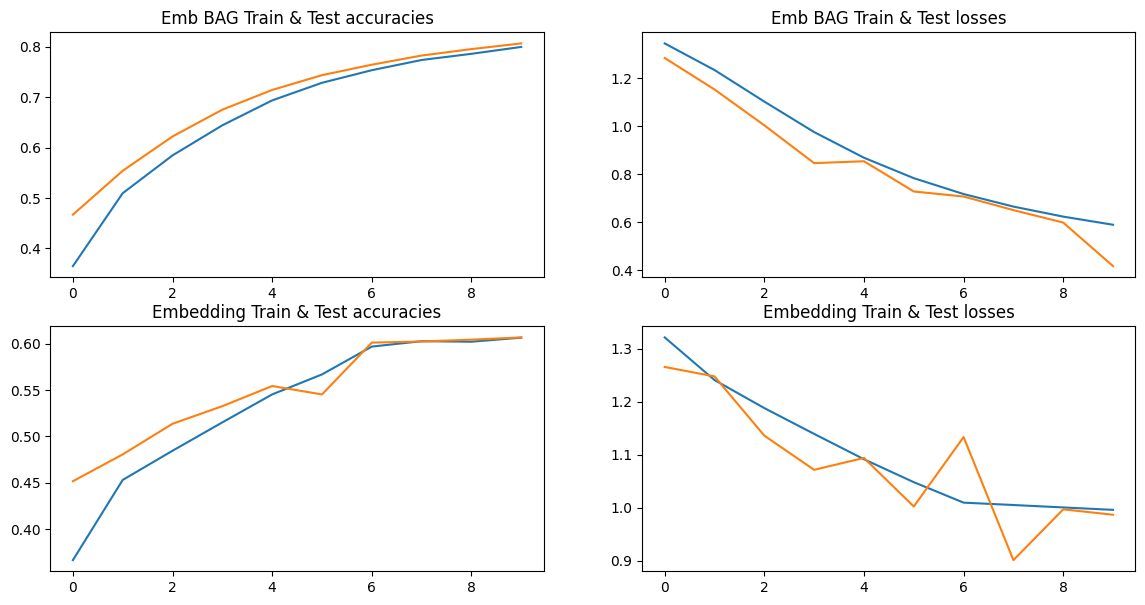

In [ ]:
''' See training and test accuracies/losses for both kinds of models.

    It's more than clear than embedding BAG model is superior in its way of using offset vectors, in comparison
    to the embedding model which relies on padding! '''
figure, axis = plt.subplots(2, 2, figsize=(14, 7))
axis[0, 0].plot(_train_accuracies)
axis[0, 0].plot(test_accuracies)
axis[0, 0].set_title('Emb BAG Train & Test accuracies')

axis[0, 1].plot(_train_losses)
axis[0, 1].plot(_test_losses)
axis[0, 1].set_title('Emb BAG Train & Test losses')

axis[1, 0].plot(mean_e_tr_accuracies)
axis[1, 0].plot(e_test_accuracies)
axis[1, 0].set_title('Embedding Train & Test accuracies')

axis[1, 1].plot(_e_train_losses)
axis[1, 1].plot(_e_test_losses)
axis[1, 1].set_title('Embedding Train & Test losses')

plt.show()